In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data Manipulation
This section is about the treatment of missing values and outliers

In [2]:
df = pd.read_csv(r'../data/raw/diabetic_readmission_data.csv')
df.shape

(101766, 50)

In [3]:
df['readmitted_general'] = np.where(df['readmitted']== 'NO',0,1)
df[['encounter_id', 'patient_nbr']] = df[['encounter_id', 'patient_nbr']].astype(str)
df.dtypes


encounter_id                object
patient_nbr                 object
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

## Missing values

In [4]:
df.isna().sum()

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [5]:
(df == '?').sum() / df.shape[0]

encounter_id                0.000000
patient_nbr                 0.000000
race                        0.022336
gender                      0.000000
age                         0.000000
weight                      0.968585
admission_type_id           0.000000
discharge_disposition_id    0.000000
admission_source_id         0.000000
time_in_hospital            0.000000
payer_code                  0.395574
medical_specialty           0.490822
num_lab_procedures          0.000000
num_procedures              0.000000
num_medications             0.000000
number_outpatient           0.000000
number_emergency            0.000000
number_inpatient            0.000000
diag_1                      0.000206
diag_2                      0.003518
diag_3                      0.013983
number_diagnoses            0.000000
max_glu_serum               0.000000
A1Cresult                   0.000000
metformin                   0.000000
repaglinide                 0.000000
nateglinide                 0.000000
c

Missing values in max_glu_serum and A1Cresult are not realy missing values. Not measured was reported as None which is automatically a missing value for pandas library.
source: https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008

In [6]:
df.fillna({'max_glu_serum': 'Not measured',
           'A1Cresult': 'Not measured'}, inplace=True)
df.isna().sum().value_counts()

0    51
Name: count, dtype: int64

weight and payer_code were removed due to the high percentage of missing values and the low explainability they may have with readmissions

In [7]:
df.drop(['weight', 'payer_code'], axis = 1, inplace=True)

In [8]:
df['race'].value_counts(normalize=True)

race
Caucasian          0.747784
AfricanAmerican    0.188766
?                  0.022336
Hispanic           0.020017
Other              0.014799
Asian              0.006299
Name: proportion, dtype: float64

medical_specialty missing values are considered as a new category as it may be an informative feature for the target variable. This also happened with primary diagnosis and secondary diagnoses (missingness was replaced by "Missing")

In the case of race, as missing values were approximately 2% of the values they were added to "Other"

In [9]:
df[['medical_specialty',
    'diag_1',
    'diag_2',
    'diag_3']] = df[['medical_specialty',
                     'diag_1',
                     'diag_2',
                     'diag_3']].apply(lambda x: x.str.replace('?', 'Missing'), axis = 1)

df['race'] = df['race'].str.replace('?', 'Other')
df = df.loc[(df['gender'] != 'Unknown/Invalid'),:]

In [10]:
(df == '?').sum() / df.shape[0]

encounter_id                0.0
patient_nbr                 0.0
race                        0.0
gender                      0.0
age                         0.0
admission_type_id           0.0
discharge_disposition_id    0.0
admission_source_id         0.0
time_in_hospital            0.0
medical_specialty           0.0
num_lab_procedures          0.0
num_procedures              0.0
num_medications             0.0
number_outpatient           0.0
number_emergency            0.0
number_inpatient            0.0
diag_1                      0.0
diag_2                      0.0
diag_3                      0.0
number_diagnoses            0.0
max_glu_serum               0.0
A1Cresult                   0.0
metformin                   0.0
repaglinide                 0.0
nateglinide                 0.0
chlorpropamide              0.0
glimepiride                 0.0
acetohexamide               0.0
glipizide                   0.0
glyburide                   0.0
tolbutamide                 0.0
pioglita

## Outliers

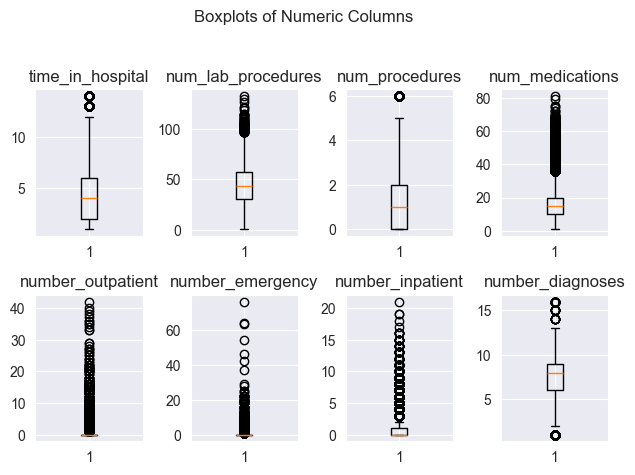

In [11]:
cat_columns = list(df.select_dtypes(object).columns)
cat_columns.extend(['admission_type_id',
                    'discharge_disposition_id',
                    'admission_source_id'])
df[cat_columns] = df[cat_columns].astype('category')
num_columns = list(df.select_dtypes(include = ['number']).columns)
num_df = df[num_columns]
fig, axes = plt.subplots(2, 4)

axes_flat = axes.flatten()

for ax, column in zip(axes_flat, num_df.columns):
    ax.boxplot(num_df[column])
    ax.set_title(column)

plt.suptitle('Boxplots of Numeric Columns')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

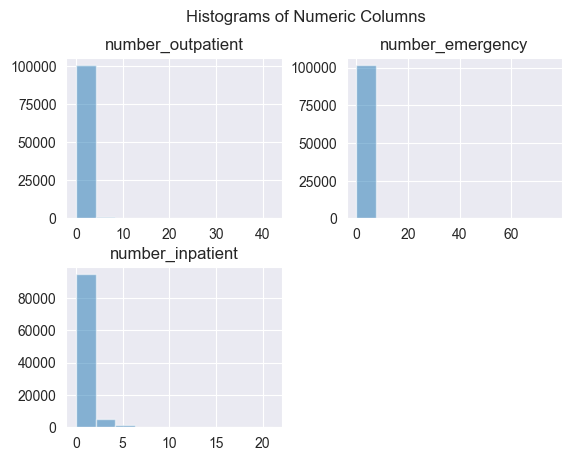

In [12]:
df[['number_outpatient',
    'number_emergency',
    'number_inpatient']].hist(alpha=0.5, bins=10)
plt.suptitle('Histograms of Numeric Columns')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Outliers were removed with IQR method using alpha = 1.5
Due to the distribution of number_outpatient, number_impatient and number_emergency it doesn't make sense to disregard outliers with the IQR method

In [13]:
no_iqr_considered = ['number_outpatient',
                     'number_emergency',
                     'number_inpatient']
quantiles = df[num_columns]\
    .drop(no_iqr_considered, axis = 1)\
    .quantile([0.25,0.75])
quantiles

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,readmitted_general
0.25,2.0,31.0,0.0,10.0,6.0,0.0
0.75,6.0,57.0,2.0,20.0,9.0,1.0


In [14]:
IQR = quantiles.loc[0.75] - quantiles.loc[0.25]
IQR

time_in_hospital       4.0
num_lab_procedures    26.0
num_procedures         2.0
num_medications       10.0
number_diagnoses       3.0
readmitted_general     1.0
dtype: float64

In [15]:
print(f'Rows before removing outliers: {df.shape[0]}')
for i in quantiles.columns:
    df[i] = df[i].where(
        (df[i] <= quantiles[i][0.75] + IQR[i]*1.5) &
        (df[i] >= quantiles[i][0.25] - IQR[i]*1.5)
    )

df.dropna(inplace=True)
print(f'Rows after removing outliers: {df.shape[0]}')

Rows before removing outliers: 101763
Rows after removing outliers: 93075


In [16]:
df.to_csv(r'../data/interim/diabetic_readmission_data_interim.csv', index=False)